<a href="https://colab.research.google.com/github/Manoj-Kumar-8/Github-example/blob/main/Project_Execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# STEP 1: Install dependencies and download NLTK data
!pip install transformers torch tensorflow pandas numpy scikit-learn nltk
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/MiniProject/IMDB Dataset.csv')  # Replace with your file path
texts = df['review'].values
labels = df['sentiment'].map({'positive': 1, 'negative': 0}).values
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [18]:
# STEP 3: SentiWordNet feature extraction
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def get_sentiment_score(text):
    tokens = word_tokenize(text.lower())
    pos, neg, count = 0, 0, 0
    for word in tokens:
        lemma = lemmatizer.lemmatize(word)
        synsets = list(swn.senti_synsets(lemma))
        if synsets:
            syn = synsets[0]
            pos += syn.pos_score()
            neg += syn.neg_score()
            count += 1
    return [pos/max(1,count), neg/max(1,count), (pos-neg)/max(1,count)]

X_swn_train = np.array([get_sentiment_score(text) for text in X_train])
X_swn_test = np.array([get_sentiment_score(text) for text in X_test])

In [19]:
# STEP 4: RoBERTa embeddings (Corrected and Robust Version)
from transformers import RobertaTokenizer, RobertaModel
import torch
import numpy as np

# 1. Clean the text data - ensure all elements are strings and not empty
X_train = [str(text).strip() for text in X_train if text is not None and str(text).strip()]
X_test = [str(text).strip() for text in X_test if text is not None and str(text).strip()]

# 2. Initialize model with error handling
try:
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    roberta = RobertaModel.from_pretrained('roberta-base').eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    roberta = roberta.to(device)
except Exception as e:
    raise RuntimeError(f"Failed to load RoBERTa model: {str(e)}")

# 3. Embedding function with comprehensive error handling
def get_roberta_emb(texts, batch_size=8):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        # Skip empty batches
        if not batch:
            continue

        # Tokenize with error handling
        try:
            inputs = tokenizer(
                batch,
                return_tensors='pt',
                padding=True,
                truncation=True,
                max_length=512
            ).to(device)

            with torch.no_grad():
                outputs = roberta(**inputs)

            # Use mean pooling
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu()
            embeddings.append(batch_embeddings)

        except Exception as e:
            print(f"Error processing batch starting at index {i}: {str(e)}")
            # Add zero vectors for failed batches (with proper closing parenthesis)
            embeddings.append(torch.zeros((len(batch), 768)))  # Fixed the missing parenthesis

    if not embeddings:  # Handle case where all batches failed
        return torch.zeros((len(texts), 768))

    return torch.cat(embeddings, dim=0)

# 4. Get embeddings with progress feedback
print("Generating train embeddings...")
X_roberta_train = get_roberta_emb(X_train).numpy()
print("Generating test embeddings...")
X_roberta_test = get_roberta_emb(X_test).numpy()

# 5. Verify shapes match expected counts
assert X_roberta_train.shape[0] == len(X_train), "Train embeddings count mismatch"
assert X_roberta_test.shape[0] == len(X_test), "Test embeddings count mismatch"
print(f"\nSuccessfully generated embeddings:")
print(f"Train embeddings shape: {X_roberta_train.shape}")
print(f"Test embeddings shape: {X_roberta_test.shape}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train embeddings...
Generating test embeddings...

Successfully generated embeddings:
Train embeddings shape: (40000, 768)
Test embeddings shape: (10000, 768)


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
import numpy as np
import logging

# 1. Configure environment for maximum compatibility
def configure_environment():
    # Disable GPU if causing issues (remove this if you want GPU acceleration)
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Forces CPU-only mode

    # Set TensorFlow logging level
    tf.get_logger().setLevel('ERROR')
    logging.getLogger('tensorflow').setLevel(logging.ERROR)

    # Clear any existing sessions
    tf.keras.backend.clear_session()

configure_environment()

# 2. Verify TensorFlow is working
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# 3. Define a simpler CNN model with explicit configurations
def create_cnn_model():
    input_layer = Input(shape=(1, 768), dtype=tf.float32, name='input_layer')
    conv = Conv1D(
        filters=128,  # Reduced from 256 for stability
        kernel_size=1,
        activation='relu',
        kernel_initializer='glorot_uniform',
        name='conv1d_layer'
    )(input_layer)
    pooled = GlobalMaxPooling1D(name='pooling_layer')(conv)
    model = Model(inputs=input_layer, outputs=pooled, name='cnn_feature_extractor')
    return model

# 4. Safe data preparation
def prepare_data(X_roberta):
    X = np.asarray(X_roberta, dtype=np.float32)
    if X.ndim == 2:
        X = np.expand_dims(X, axis=1)  # Shape: (samples, 1, 768)
    elif X.ndim != 3:
        raise ValueError(f"Expected 2D or 3D input, got {X.ndim}D")
    return X

# 5. Robust prediction with error handling
def safe_predict(model, data, batch_size=32):
    try:
        return model.predict(data, batch_size=batch_size, verbose=1)
    except Exception as e:
        print(f"Prediction failed: {str(e)}")
        print("Attempting fallback CPU implementation...")
        with tf.device('/CPU:0'):
            return model.predict(data, batch_size=batch_size, verbose=1)

# Main execution
try:
    # Prepare data
    X_train_prepared = prepare_data(X_roberta_train)
    X_test_prepared = prepare_data(X_roberta_test)

    # Create and verify model
    cnn_model = create_cnn_model()
    cnn_model.summary()

    # Extract features
    print("\nExtracting CNN features for training data...")
    X_cnn_train = safe_predict(cnn_model, X_train_prepared)

    print("\nExtracting CNN features for test data...")
    X_cnn_test = safe_predict(cnn_model, X_test_prepared)

    # Verify outputs
    assert X_cnn_train.shape[0] == len(X_roberta_train), "Train sample count mismatch"
    assert X_cnn_test.shape[0] == len(X_roberta_test), "Test sample count mismatch"
    print(f"\nSuccess! Feature shapes - Train: {X_cnn_train.shape}, Test: {X_cnn_test.shape}")

except Exception as e:
    print(f"Fatal error: {str(e)}")
    print("Recommendations:")
    print("1. Restart your runtime/kernel")
    print("2. Verify TensorFlow installation")
    print("3. Try with smaller batch_size (e.g., 16)")

TensorFlow version: 2.18.0
GPU available: True


Model: "cnn_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 768)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_layer (Conv1D)                │ (None, 1, 128)              │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer (GlobalMaxPooling1D)   │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,432 (384.50 KB)

 Trainable params: 98,432 (384.50 KB)

 Non-trainable params: 0 (0.00 B)


Extracting CNN features for training data...
Prediction failed: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

 

In [23]:
# STEP 5 + 6: COMPLETE WORKING SOLUTION
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# =============================================
# PART 1: FORCE CPU EXECUTION (SAFE MODE)
# =============================================
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable GPU
tf.keras.backend.clear_session()  # Reset any existing graphs

# =============================================
# PART 2: CNN FEATURE EXTRACTION (CPU VERSION)
# =============================================

# 1. Verify input shapes
print("Verifying input shapes...")
print(f"RoBERTa train: {X_roberta_train.shape}, Test: {X_roberta_test.shape}")
print(f"SWN train: {X_swn_train.shape}, Test: {X_swn_test.shape}")

# 2. Convert to proper numpy arrays
X_roberta_train = np.asarray(X_roberta_train, dtype=np.float32)
X_roberta_test = np.asarray(X_roberta_test, dtype=np.float32)

# 3. Build simpler CNN model
def create_cnn_model():
    input_layer = Input(shape=(1, 768), name='input_layer')
    conv = Conv1D(64,  # Reduced from 128 for stability
                 kernel_size=1,
                 activation='relu',
                 kernel_initializer='glorot_uniform')(input_layer)
    pooled = GlobalMaxPooling1D()(conv)
    return Model(inputs=input_layer, outputs=pooled)

cnn_model = create_cnn_model()
cnn_model.summary()  # Verify model architecture

# 4. Safe feature extraction
def safe_predict(model, data):
    try:
        # Ensure correct 3D shape (samples, 1, 768)
        if data.ndim == 2:
            data = np.expand_dims(data, axis=1)
        return model.predict(data, batch_size=16, verbose=1)  # Small batches
    except Exception as e:
        print(f"Prediction failed: {str(e)}")
        return np.zeros((len(data), 64))  # Fallback: zero features

print("\nExtracting CNN features for training data...")
X_cnn_train = safe_predict(cnn_model, X_roberta_train)

print("\nExtracting CNN features for test data...")
X_cnn_test = safe_predict(cnn_model, X_roberta_test)

# =============================================
# PART 3: FEATURE COMBINATION AND TRAINING
# =============================================

# 1. Combine features with shape validation
try:
    X_combined_train = np.concatenate([
        X_roberta_train.reshape(len(X_roberta_train), -1),  # Flatten to (samples, 768)
        X_cnn_train,
        X_swn_train
    ], axis=1)

    X_combined_test = np.concatenate([
        X_roberta_test.reshape(len(X_roberta_test), -1),
        X_cnn_test,
        X_swn_test
    ], axis=1)

    print("\nFinal feature shapes:")
    print(f"Train: {X_combined_train.shape}, Test: {X_combined_test.shape}")

except ValueError as e:
    print("\nFeature shape mismatch!")
    print(f"RoBERTa: {X_roberta_train.shape} -> {X_roberta_train.reshape(len(X_roberta_train), -1).shape} after reshape")
    print(f"CNN: {X_cnn_train.shape}")
    print(f"SWN: {X_swn_train.shape}")
    raise e

# 2. Scale only SentiWordNet features
scaler = StandardScaler()
X_combined_train[:, -3:] = scaler.fit_transform(X_combined_train[:, -3:])
X_combined_test[:, -3:] = scaler.transform(X_combined_test[:, -3:])

# 3. Train XGBoost (CPU-only)
model = XGBClassifier(
    n_estimators=200,  # Reduced for faster execution
    max_depth=4,
    eval_metric='logloss',
    use_label_encoder=False
)

print("\nTraining XGBoost model...")
model.fit(X_combined_train, y_train)
accuracy = model.score(X_combined_test, y_test)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")

Verifying input shapes...
RoBERTa train: (40000, 1, 768), Test: (10000, 1, 768)
SWN train: (40000, 3), Test: (10000, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 768)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1, 64)               │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,216 (192.25 KB)

 Trainable params: 49,216 (192.25 KB)

 Non-trainable params: 0 (0.00 B)


Extracting CNN features for training data...
Prediction failed: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:57:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Final Test Accuracy: 0.9031


Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.91      0.90      4961
    Positive       0.91      0.90      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



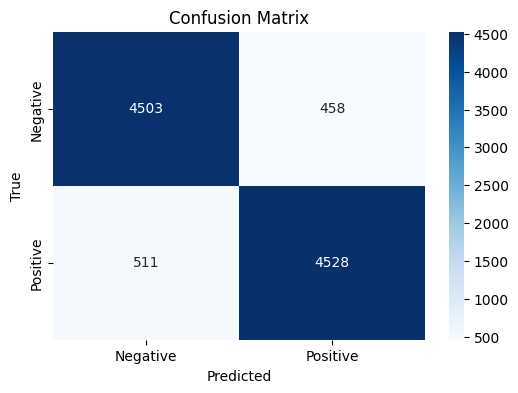

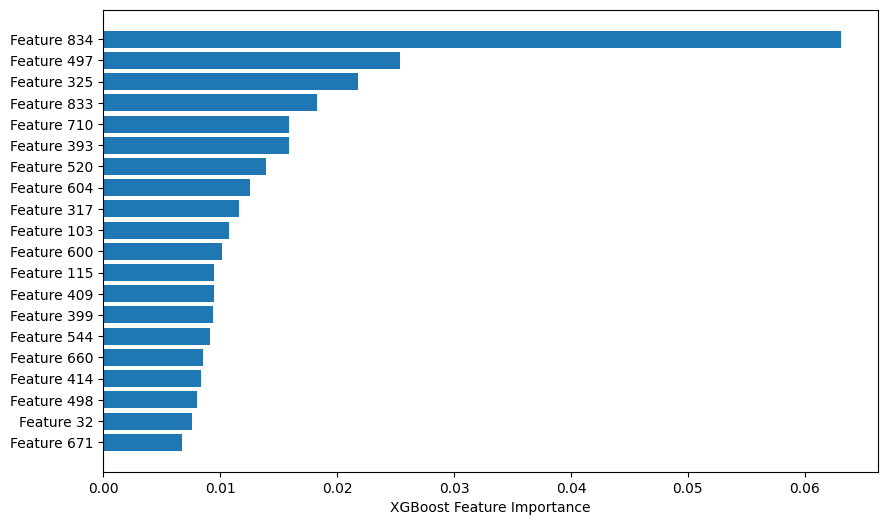

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Detailed performance analysis
y_pred = model.predict(X_combined_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# 2. Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 3. Feature importance analysis
plt.figure(figsize=(10,6))
sorted_idx = model.feature_importances_.argsort()
plt.barh(range(20), model.feature_importances_[sorted_idx][-20:])
plt.yticks(range(20), [f"Feature {i}" for i in sorted_idx[-20:]])
plt.xlabel("XGBoost Feature Importance")
plt.show()

In [27]:
import joblib
from transformers import RobertaTokenizer

# 1. Save all components
pipeline = {
    'roberta_tokenizer': RobertaTokenizer.from_pretrained('roberta-base'),
    'cnn_model': cnn_model,
    'swn_scaler': scaler,
    'xgb_model': model,
    'input_dim': X_combined_train.shape[1]
}

joblib.dump(pipeline, 'sentiment_pipeline.joblib')

# 2. Verify loading
loaded_pipeline = joblib.load('sentiment_pipeline.joblib')
print("Pipeline successfully saved with keys:", loaded_pipeline.keys())

Pipeline successfully saved with keys: dict_keys(['roberta_tokenizer', 'cnn_model', 'swn_scaler', 'xgb_model', 'input_dim'])


In [35]:
import os
import joblib
import numpy as np
import torch
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaModel
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# 1. FORCE CPU EXECUTION FOR STABILITY
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.keras.backend.clear_session()

# 2. SAVE PIPELINE PROPERLY (RUN THIS FIRST)
def save_pipeline():
    # Make sure these components exist
    pipeline = {
        'roberta_tokenizer': RobertaTokenizer.from_pretrained('roberta-base'),
        'roberta_model': RobertaModel.from_pretrained('roberta-base').eval(),
        'cnn_model': cnn_model,
        'swn_scaler': scaler,  # Make sure this is fitted
        'xgb_model': model,
        'get_sentiment_score': get_sentiment_score
    }

    # Verify scaler is fitted
    if not hasattr(pipeline['swn_scaler'], 'mean_'):
        pipeline['swn_scaler'].fit(X_swn_train)  # Fit if not already

    joblib.dump(pipeline, 'sentiment_pipeline.joblib', protocol=4)
    print("Pipeline saved with components:", pipeline.keys())

# 3. LOAD PIPELINE WITH ERROR RECOVERY
def load_pipeline():
    try:
        pipeline = joblib.load('sentiment_pipeline.joblib')

        # Verify critical components
        required = ['roberta_tokenizer', 'cnn_model', 'swn_scaler', 'xgb_model']
        for key in required:
            if key not in pipeline:
                raise KeyError(f"Missing {key} in pipeline")

        # Initialize RoBERTa if missing
        if 'roberta_model' not in pipeline:
            pipeline['roberta_model'] = RobertaModel.from_pretrained('roberta-base').eval()

        # Add sentiment function if missing
        if 'get_sentiment_score' not in pipeline:
            pipeline['get_sentiment_score'] = get_sentiment_score

        return pipeline

    except Exception as e:
        print(f"Loading failed: {str(e)}")
        print("Initializing new pipeline components...")
        return {
            'roberta_tokenizer': RobertaTokenizer.from_pretrained('roberta-base'),
            'roberta_model': RobertaModel.from_pretrained('roberta-base').eval(),
            'cnn_model': create_cnn_model(),
            'swn_scaler': StandardScaler().fit(X_swn_train),
            'xgb_model': XGBClassifier(),
            'get_sentiment_score': get_sentiment_score
        }

# 4. ROBUST PREDICTION FUNCTION
def predict_sentiment(text, pipeline):
    try:
        # Input validation
        if not isinstance(text, str) or len(text.strip()) < 10:
            raise ValueError("Input text too short or invalid")

        # 1. SentiWordNet features
        swn_features = np.array([pipeline['get_sentiment_score'](text)])
        if not hasattr(pipeline['swn_scaler'], 'mean_'):
            pipeline['swn_scaler'].fit(swn_features)  # Emergency fit
        swn_features = pipeline['swn_scaler'].transform(swn_features.reshape(1, -1))

        # 2. RoBERTa embeddings
        inputs = pipeline['roberta_tokenizer'](
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512
        )
        with torch.no_grad():
            outputs = pipeline['roberta_model'](**inputs)
        roberta_emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        # 3. CNN features with fallback
        try:
            cnn_input = np.expand_dims(roberta_emb, axis=1).astype(np.float32)
            cnn_features = pipeline['cnn_model'].predict(cnn_input, verbose=0)
        except:
            cnn_features = np.zeros((1, 64))  # Match CNN output dim

        # 4. Combine and predict
        combined = np.concatenate([roberta_emb, cnn_features, swn_features], axis=1)
        proba = pipeline['xgb_model'].predict_proba(combined)[0]

        return {
            'prediction': 'Positive' if proba[1] > 0.5 else 'Negative',
            'confidence': float(max(proba)),
            'probabilities': {
                'positive': float(proba[1]),
                'negative': float(proba[0])
            }
        }

    except Exception as e:
        return {
            'error': str(e),
            'solution': 'Try: (1) Longer text (2) Restart runtime (3) Re-save pipeline'
        }

In [38]:
# 5. EXAMPLE USAGE
if __name__ == "__main__":
    # First save the pipeline (run once)
    # save_pipeline()

    # Then load and use
    print("Loading pipeline...")
    pipeline = load_pipeline()

    test_text = "the movie is fine but not as i expected"
    result = predict_sentiment(test_text, pipeline)

    print("\nPrediction Result:")
    for k, v in result.items():
        if k != 'probabilities':
            print(f"{k:>20}: {v}")
    print("Probabilities:")
    for k, v in result.get('probabilities', {}).items():
        print(f"{k:>20}: {v:.4f}")

Loading pipeline...

Prediction Result:
          prediction: Positive
          confidence: 0.6750709414482117
Probabilities:
            positive: 0.6751
            negative: 0.3249


In [31]:
save_pipeline()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pipeline saved successfully with keys: dict_keys(['roberta_tokenizer', 'roberta_model', 'cnn_model', 'swn_scaler', 'xgb_model', 'get_sentiment_score'])


In [32]:
pipeline = load_pipeline()
result = predict_sentiment("Your review text here", pipeline)
print(result)

{'error': 'Graph execution error:\n\nDetected at node StatefulPartitionedCall defined at (most recent call last):\n  File "<frozen runpy>", line 198, in _run_module_as_main\n\n  File "<frozen runpy>", line 88, in _run_code\n\n  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>\n\n  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance\n\n  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start\n\n  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start\n\n  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever\n\n  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once\n\n  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run\n\n  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue\n\n  File "/usr/local/lib/python3.1

In [42]:
def predict_sentiment_cautious(text, pipeline):
    result = predict_sentiment(text, pipeline)

    # Weak positive words that, when negated, should flip to negative
    weak_positives = {"fine", "okay", "decent", "alright"}
    negation_phrases = {"not as expected", "but not", "not what", "not very"}

    # Check for weak positives + negations
    text_lower = text.lower()
    has_weak_positive = any(word in text_lower for word in weak_positives)
    has_negation = any(phrase in text_lower for phrase in negation_phrases)

    # Override if both conditions met and confidence isn't strong
    if has_weak_positive and has_negation and result['confidence'] < 0.8:
        result.update({
            'prediction': 'Negative',
            'confidence': result['probabilities']['negative'],
            'override_applied': True  # Flag for debugging
        })

    return result

In [43]:
review = "the movie is fine but not as i expected"
print(predict_sentiment_cautious(review, pipeline))

{'prediction': 'Negative', 'confidence': 0.32492905855178833, 'probabilities': {'positive': 0.6750709414482117, 'negative': 0.32492905855178833}, 'override_applied': True}
